# Description

* Creating OTUs with usearch 
* Taxonomy assignment with QIIME using SILVA database version 132.
* Filtering out Chloroplasts and Mitochondria with Mothur.

# Setting variables

In [1]:
import os

baseDir = '/home/sam/notebooks/goldenrod_assembly/data'

qcFinal = os.path.join(baseDir, 'QC', 'finalQC.fasta')

workDir = os.path.join(baseDir, 'OTU_binning')

taxlist = '/home/sam/databases/SILVA_132_QIIME_release/taxonomy/16S_only/97/taxonomy_7_levels.txt'
taxfasta = '/home/sam/databases/SILVA_132_QIIME_release/rep_set/rep_set_16S_only/97/silva_132_97_16S.fna'

tax_ref = os.path.join(workDir, 'taxa_ref_SILVA_132.fasta')

output_tax_table = os.path.join(workDir, 'otusn_tax_assignments.txt')

nprocs = 15

# Init

In [2]:
import os
import sys
import glob
import pandas as pd
#from cogent.parse.fasta import MinimalFastaParser as parse
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np


In [3]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
%cd $workDir

/home/sam/notebooks/goldenrod_assembly/data/OTU_binning


### Symlinking qc'ed seq file

In [7]:
!ln -s $qcFinal .

ln: failed to create symbolic link './finalQC.fasta': File exists


In [8]:
qcFinal = os.path.join(workDir, os.path.split(qcFinal)[1])
!ls -thlc $qcFinal

lrwxrwxrwx 1 sam sam 60 Jun 30 19:59 /home/sam/notebooks/goldenrod_assembly/data/OTU_binning/finalQC.fasta -> /home/sam/notebooks/goldenrod_assembly/data/QC/finalQC.fasta


## Remove short sequences (<400 bp)

In [9]:
#qcFinal_long = qcFinal.replace('.fasta', '_long.fasta')
QCreadlengths = []

for record in SeqIO.parse(qcFinal, 'fasta'):
    QCreadlengths.append(len(record.seq))

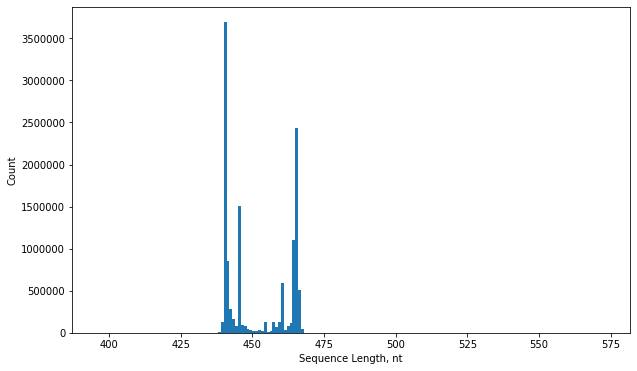

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
h = ax.hist(np.array(QCreadlengths), 
            bins=range(min(np.array(QCreadlengths)), 
                       max(np.array(QCreadlengths)) + 1, 1))
xl = ax.set_xlabel("Sequence Length, nt")
yl = ax.set_ylabel("Count")
fig.set_size_inches((10,6))

In [11]:
QCreadlengths = None

In [12]:
qcFinal_long = qcFinal.replace('.fasta', '_long.fasta')
tooshort = 0

with open(qcFinal_long, 'w') as outfasta:
    for record in SeqIO.parse(os.path.join(workDir, qcFinal), "fasta"):
        if len(record.seq) >= 400:
            outfasta.write('>' + record.id + '\n' + str(record.seq) + '\n')
        else:
            tooshort += 1

In [13]:
print(tooshort)

2


In [14]:
qcFinal = qcFinal_long
qcFinal

'/home/sam/notebooks/goldenrod_assembly/data/OTU_binning/finalQC_long.fasta'

# Just unique sequences

In [ ]:
cmd =  'mothur "#unique.seqs(fasta={})"'.format(qcFinal)
!$cmd | tail -n 30

In [ ]:
qcFinalUniq = os.path.splitext(qcFinal)[0] + '.unique.fasta'

ret = !grep -c ">" $qcFinalUniq
print ('Number of unique sequences: {}'.format(ret[0]))

# Formatting seq names for usearch

In [ ]:
qcFinalName = os.path.splitext(qcFinal)[0] + '.names'

counts = {}
with open(qcFinalName) as iFH:
    for line in iFH:
        seedID, seqIDs = line.split("\t")
        count = len(seqIDs.split(","))
        counts[seedID] = count 

In [ ]:
counts

In [ ]:
sample_list = list(set([i.split('_')[0] for i in counts if counts[i] > 1]))
len(sample_list)

In [ ]:
qcFinalUs = os.path.splitext(qcFinalUniq)[0] + '.usearch_names.fasta'

with open(qcFinalUs, 'w') as oFH:
    for entry in SeqIO.parse(open(qcFinalUniq),'fasta'):
        #n, s = fasta.id, fasta.seq.tostring()
        n, s = entry.id, str(entry.seq)
        if counts[n] > 1:
            oFH.write(">%s;size=%s;\n%s\n"%(n,counts[n],s))
        else:
            continue

In [ ]:
#!cd $workDir; \
!head -n 6 $qcFinalUs

In [ ]:
!grep -c ">" $qcFinalUs

# Usearch pipeline

In [ ]:
qcFinalUsSort = os.path.splitext(qcFinalUs)[0] + '_sorted.fasta'
cmd = 'usearch -sortbysize {} -fastaout {} -minsize 2'.format(qcFinalUs, qcFinalUsSort)
!$cmd 

In [ ]:
!head $qcFinalUsSort
!echo 
!tail $qcFinalUsSort

In [ ]:
otuFile = 'otus.fasta'
cmd = 'usearch -cluster_otus {} -otus {}'.format(qcFinalUsSort, otuFile)
!$cmd 

In [ ]:
otuFileRn = os.path.splitext(otuFile)[0] + 'n.fasta'

In [ ]:
%%bash -s "$otuFile" "$otuFileRn"

 bioawk -c fastx '{print ">" "OTU" "." NR "\n" $seq}' $1 > $2

In [27]:
!head -n 4 $otuFileRn

>OTU.1
CCTACGGGGGGCTGCAGTGGGGAATATTGCACAATGGGCGCAAGCCTGATGCAGCGACGCCGCGTGAGGGATGACGGCCTTCGGGTTGTAAACCTCTTTCAGTAGGGAAGAAGCGAAAGTGACGGTACCTGCAGAAGAAGCGCCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGCGCAAGCGTTATCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGTTTGTCGCGTCTGCCGTGAAAGTCCGGGGCTCAACTCCGGATCTGCGGTGGGTACGGGCAGACTAGAGTGATGTAGGGGAGACTGGAATTCCTGGTGTAGCGGTGAAATGCGCAGATATCAGGAGGAACACCGATGGCGAAGGCAGGTCTCTGGGCATTAACTGACGCTGAGGAGCGAAAGCATGGGGAGCGAACAGGATTAGATACCCCAGTAGTC
>OTU.2
CCTACGGGGGGCTGCAGTAGGGAATCTTCCGCAATGGACGAAAGTCTGACGGAGCAACGCCGCGTGAGTGATGAAGGCTTTCGGGTCGTAAAACTCTGTTGTTAGGGAAGAACAAGTACGAGAGTAACTGCTCGTACCTTGACGGTACCTAACCAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGTTTCTTAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGGTCATTGGAAACTGGGGAACTTGAGTGCAGAAGAGAAAAGCGGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAACACCAGTGGCGAAGGCGGCTTTTTGGTCTGTAACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGGATTAGATACCCCAGTAGTC


In [28]:
!grep -c ">" $otuFileRn

27603


### Assigning taxonomy

In [29]:
tax_levels = {0: 'd', 1: 'p', 2: 'c', 3: 'o', 4: 'f', 5: 'g', 6: 's'}
tax_dict = {}
with open(taxlist) as f:
    for line in f:
        (key, val) = line.split('\t')
        tax_dict[key] = val.replace('\n', '')
        
with open(tax_ref, 'w') as outref:
    for record in SeqIO.parse(taxfasta, 'fasta'):
        tax = tax_dict[record.id].split(';')
        header = record.id + ';tax=' + tax[0].replace('D_0__', tax_levels[0] + ':')
        for i in range(1, len(tax)):
            header = header + ',' + tax[i].replace('D_' + str(i) + '__', tax_levels[i] + ':')
            
        outref.write('>' + header + '\n' + str(record.seq) + '\n')


In [30]:
tax_cmd = ' '.join(['vsearch --sintax', otuFileRn, 
                    '--db', tax_ref, 
                    '--sintax_cutoff', str(0.80),
                    '--tabbedout', output_tax_table])

!$tax_cmd

vsearch v2.13.3_linux_x86_64, 125.8GB RAM, 40 cores
https://github.com/torognes/vsearch

Reading file /home/sam/notebooks/goldenrod_assembly/data/OTU_binning/taxa_ref_SILVA_132.fasta 100%                   
243651134 nt in 172222 seqs, min 900, max 2961, avg 1415
Counting k-mers 100%                                            
Creating k-mer index 100%                                                                                                                                                                                                      
Classifying sequences 100%                                                                                                                                                                                                        
Classified 27551 of 27603 sequences (99.81%)


### Removing Chloroplast, Eukaryal and mitochodria sequences

In [31]:
best_tax_dict = {}
with open(output_tax_table) as f:
    for line in f:
        line_list = line.split('\t')
        key = line_list[0]
        val = line_list[3]
        best_tax_dict[key] = val

In [32]:
to_rm_file = os.path.join(workDir, 'to_remove_tax.accnos')
chloro_count = 0
mito_count = 0
euk_count = 0
unclass_count = 0
with open(to_rm_file, 'w') as rmfile:
    for OTU in best_tax_dict:
        if 'Chloroplast' in best_tax_dict[OTU]:
            rmfile.write(OTU + '\n')
            chloro_count += 1
        elif 'Mitochondria' in best_tax_dict[OTU]:
            rmfile.write(OTU + '\n')
            mito_count += 1
        elif 'Eukaryota' in best_tax_dict[OTU]:
            rmfile.write(OTU + '\n')
            euk_count += 1
        elif len(best_tax_dict[OTU]) == 0:
            rmfile.write(OTU + '\n')
            unclass_count += 1
            
print('Chloroplast OTUs: ' + str(chloro_count))   
print('Mitochondrial OTUs: ' + str(mito_count))
print('Eukarya OTUs: ' + str(euk_count))
print('Unclassified OTUs: ' + str(unclass_count))   

Chloroplast OTUs: 130
Mitochondrial OTUs: 35
Eukarya OTUs: 0
Unclassified OTUs: 52


In [33]:
ret = !wc -l $to_rm_file
print ('Number of lines: {}'.format(ret[0]))
!head $to_rm_file

Number of lines: 217 /home/sam/notebooks/goldenrod_assembly/data/OTU_binning/to_remove_tax.accnos
OTU.21
OTU.30
OTU.20
OTU.116
OTU.195
OTU.240
OTU.381
OTU.413
OTU.430
OTU.445


In [34]:
cmd = 'mothur "#remove.seqs(fasta={}, accnos={})"'.format(otuFileRn, to_rm_file)
!$cmd | tail -n 30

http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

For questions and analysis support, please visit our forum at https://forum.mothur.org

Type 'quit()' to exit program

[NOTE]: Setting random seed to 19760620.

Script Mode


mothur > remove.seqs(fasta=otusn.fasta, accnos=/home/sam/notebooks/goldenrod_assembly/data/OTU_binning/to_remove_tax.accnos)
Removed 217 sequences from your fasta file.

Output File Names:
otusn.pick.fasta


mothur > quit()


It took 0 seconds to run 2 commands from your script.



In [35]:
otuFilePick = os.path.splitext(otuFileRn)[0] + '.pick.fasta'

ret = !grep -c ">" $otuFileRn
print ('Pre-filter: number of sequences: {}'.format(ret[0]))

ret = !grep -c ">" $otuFilePick
print ('Post-filter: number of sequences: {}'.format(ret[0]))

Pre-filter: number of sequences: 27603
Post-filter: number of sequences: 27386


# Mapping reads

In [15]:
qcFinal

'/home/sam/notebooks/goldenrod_assembly/data/OTU_binning/finalQC_long.fasta'

In [16]:
cmd_perl = 's/^>(.+)(_[^_]+)\n\$/>\$1\$2\_\$.;barcodelabel=\$1\n/' 

seqFile = os.path.splitext(qcFinal)[0] + '_usearchfmt.fasta'

cmd = 'perl -pe "{}" {} > {}'.format(cmd_perl, qcFinal, seqFile)
!$cmd

In [17]:
!head -n 6 $seqFile

>SRR8905901_56872_1;barcodelabel=SRR8905901
CCTACGGGGGGCTGCAGTGGGGAATCTTGCACAATGGGCGAAAGCCTGATGCAGCGACGCCGCGTGGGGGATGAAGCTTTTCGGAGTGTAAACCCCTTTCGACTGGGACGAATGCCTCGCAAGAGGAGTGACGGTACCAGTATAAGAAGCCCCGGCTAACTACGTGCCAGCAGCCGCGGTAAGACGTAGGGGGCCAGCGTTGTTCGGAATTACTGGGTGTAAAGGGTTCGTAGGCGGTGTGGCAAGTCGGGAGTGAAATCCCTGGGCTCAACCCAGGGACTGCTTCCGAAACTGCTGTGCCTGAGTGTGAGAGAGGCTCGTGGAATTGCAGGTGTAGCGGTGAAATGCGTAGATATCTGCAGGAACACCCGTGGCGAAAGCGGCGAGCTGGATCACTACTGACGCTGAGGAACGAAAGCTAGGGGAGCAAACAGGATTAGATACCCTGGTAGTC
>SRR8906083_22803_3;barcodelabel=SRR8906083
CCTACGGGGCGCTGCAGTGGGGAATCTTGCGCAAATGCGGGAAACCGTGACGCAGCGACGCCGCGTGGGGGAAGAAGGCCTTCGGGTTGTAAACCTCTTTCAGGAGGGACGAAGCTACTCGGGTTAATAGACCAGAGGGTGACGGTACCTCCAGAAGAAGCCCCGGCTGACTACGTGCCAGCAGCGGCGGTAATACGTAGGGGGCAAGCGTTGTCCGAATTTATTGGGCGTAAAGAGCTAGTAGGCGGCTTGGTAGGTCCGCGGTGAAAACTCGAGGCTCAACCGCGAGATGGCGGCGGAAACCACTGGGCTAGAGTCCGGAAGAGGAGAGTGGAATTCCCGGTGTAGCGGTGAAATGCGCAGATGTCGGGAAGAACACCTATGGCGAAGGCAGCTCTCTGGGACGGTACTGACGCTGAGACGCGAAAGCGTGGGGAGCGAACAGGATTAGATACCC

In [18]:
#see how many Gb this file is.
!du -h $seqFile

5.9G	/home/sam/notebooks/goldenrod_assembly/data/OTU_binning/finalQC_long_usearchfmt.fasta


In [19]:
#spliting file because it is too big
!pyfasta split -n 5 $seqFile


creating new files:
/home/sam/notebooks/goldenrod_assembly/data/OTU_binning/finalQC_long_usearchfmt.0.fasta
/home/sam/notebooks/goldenrod_assembly/data/OTU_binning/finalQC_long_usearchfmt.1.fasta
/home/sam/notebooks/goldenrod_assembly/data/OTU_binning/finalQC_long_usearchfmt.2.fasta
/home/sam/notebooks/goldenrod_assembly/data/OTU_binning/finalQC_long_usearchfmt.3.fasta
/home/sam/notebooks/goldenrod_assembly/data/OTU_binning/finalQC_long_usearchfmt.4.fasta


In [20]:
g = os.path.join(workDir, 'finalQC_long_usearchfmt.*.fasta')
fileList = glob.glob(g)
fileList 

['/home/sam/notebooks/goldenrod_assembly/data/OTU_binning/finalQC_long_usearchfmt.2.fasta',
 '/home/sam/notebooks/goldenrod_assembly/data/OTU_binning/finalQC_long_usearchfmt.0.fasta',
 '/home/sam/notebooks/goldenrod_assembly/data/OTU_binning/finalQC_long_usearchfmt.1.fasta',
 '/home/sam/notebooks/goldenrod_assembly/data/OTU_binning/finalQC_long_usearchfmt.4.fasta',
 '/home/sam/notebooks/goldenrod_assembly/data/OTU_binning/finalQC_long_usearchfmt.3.fasta']

In [21]:
otuFilePick = os.path.join(workDir, 'otusn.pick.fasta')
otuFilePick

'/home/sam/notebooks/goldenrod_assembly/data/OTU_binning/otusn.pick.fasta'

In [ ]:
# running usearch on each split file
for f in fileList:
    sys.stderr.write('Processing {}\n'.format(f))

    ff,_ = os.path.splitext(f)
    _,i = os.path.splitext(ff)
    uc = 'readmap{}.uc'.format(i.lstrip('.')) 

    !usearch \
        -usearch_global $f \
        -db $otuFilePick \
        -strand plus \
        -id 0.97 \
        -maxaccepts 0 \
        -maxrejects 0 \
        -uc $uc \
        -threads $nprocs

usearch v11.0.667_i86linux32, 4.0Gb RAM (132Gb total), 40 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only

00:00 54Mb    100.0% Reading /home/sam/notebooks/goldenrod_assembly/data/OTU_binning/otusn.pick.fasta


Processing /home/sam/notebooks/goldenrod_assembly/data/OTU_binning/finalQC_long_usearchfmt.2.fasta


00:01 20Mb    100.0% Masking (fastnucleo)
00:01 21Mb    100.0% Word stats          
00:01 21Mb    100.0% Alloc rows
00:02 67Mb    100.0% Build index


In [31]:
ucFile = 'readmap.uc'
!cat readmap[0-9].uc > $ucFile

In [32]:
otu_table_file = 'otu_table.txt'
cmd = 'python2 /home/sam/repo/edgar_python_scripts/uc2otutab.py {} > {}'.format(ucFile, otu_table_file)
!$cmd 

readmap.uc 100.0%   


In [33]:
# make sure no existing biome file
otu_biom_file = 'otu_table.biom'
if os.path.isfile(otu_biom_file):
    os.unlink(otu_biom_file)
    
cmd = 'biom convert -i {} -o {} --table-type "OTU table" --to-json'.format(otu_table_file, otu_biom_file)
!$cmd

In [34]:
# make sure no existing summary file
otu_sum_file = 'otu_table_summary.txt'
if os.path.isfile(otu_sum_file):
    os.unlink(otu_sum_file)
    
cmd = 'biom summarize-table -i {} -o {}'.format(otu_biom_file, otu_sum_file)
!$cmd

In [35]:
!cat $otu_sum_file

Num samples: 207
Num observations: 27386
Total count: 13344789
Table density (fraction of non-zero values): 0.140

Counts/sample summary:
 Min: 97.0
 Max: 312757.0
 Median: 62849.000
 Mean: 64467.580
 Std. dev.: 39353.873
 Sample Metadata Categories: None provided
 Observation Metadata Categories: None provided

Counts/sample detail:
SRR8906026: 97.0
SRR8906028: 986.0
SRR8906021: 1709.0
SRR8906200: 12410.0
SRR8906208: 16086.0
SRR8906161: 16988.0
SRR8905939: 17963.0
SRR8905940: 18587.0
SRR8906085: 19213.0
SRR8906159: 19379.0
SRR8906056: 19941.0
SRR8906201: 19946.0
SRR8906155: 20117.0
SRR8905989: 20313.0
SRR8906024: 20439.0
SRR8905948: 21255.0
SRR8905866: 21569.0
SRR8906050: 21661.0
SRR8905941: 22624.0
SRR8906207: 22678.0
SRR8906057: 23725.0
SRR8905998: 23873.0
SRR8905942: 24665.0
SRR8905865: 24759.0
SRR8906052: 24826.0
SRR8906153: 24989.0
SRR8906158: 25134.0
SRR8906205: 25140.0
SRR8906079: 25508.0
SRR8905863: 25679.0
SRR8906203: 25987.0
SRR8906049: 26415.0
SRR8906054: 27183.0
SRR8906016